# 1. Replicate the ViT architecture we created with in-built PyTorch transformer layers.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup


# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

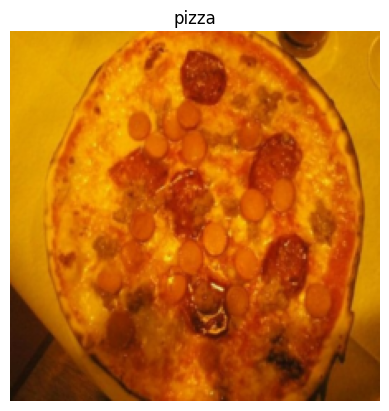

In [9]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label]);
plt.axis(False);

## 1.1 Replicating ViT

In [10]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropiate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

In [11]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True,)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [12]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               att_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000, # number of classes in our classification problem
               ):
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size **2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout values
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the Transformer Encoder Block
    self.transformer_encoder = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=embedding_dim, # embedding size from table 1
                                                                               nhead=num_heads, # heads from table 1
                                                                               dim_feedforward=mlp_size, # MLP size from table
                                                                               dropout=mlp_dropout,
                                                                               activation="gelu",
                                                                               batch_first=True,
                                                                               norm_first=True,) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches+1, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional - to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [13]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.4018,  0.8634,  1.0812]], grad_fn=<AddmmBackward0>)

In [14]:
from torchinfo import summary

model = ViT(num_classes=len(class_names))
summary(model=model,
        input_size=(1, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)       [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                 [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)            [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderLayer (0)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─TransformerEncoderLayer (1)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─Transformer

# 2. Turn the custom ViT architecture we created into a Python script, for example, vit.py

In [15]:
%%writefile vit.py
import torch
from torch import nn

# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropiate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               att_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000, # number of classes in our classification problem
               ):
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size **2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout values
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the Transformer Encoder Block
    self.transformer_encoder = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=embedding_dim, # embedding size from table 1
                                                                               nhead=num_heads, # heads from table 1
                                                                               dim_feedforward=mlp_size, # MLP size from table
                                                                               dropout=mlp_dropout,
                                                                               activation="gelu",
                                                                               batch_first=True,
                                                                               norm_first=True,) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches+1, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional - to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

Writing vit.py


In [16]:
!python vit.py

In [17]:
from vit import ViT

imported_vit = ViT()
summary(model=imported_vit,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ViT                                      [1, 1000]                 152,064
├─PatchEmbedding: 1-1                    [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                      [1, 768, 196]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Sequential: 1-3                        [1, 197, 768]             --
│    └─TransformerEncoderLayer: 2-3      [1, 197, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-4      [1, 197, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-5      [1, 197, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-6      [1, 197, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-7      [1, 197, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-8      [1, 197, 768]             7,087,872
│    └─TransformerEncoderLayer: 2

# 3. Train a pretrained ViT feature extractor model (like the one we made in 08. PyTorch Paper Replicating section 10) on 20% of the pizza, steak and sushi data like the dataset we used in 07. PyTorch Experiment Tracking section 7.3.

In [18]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [19]:
# Setup training directory paths
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_20_percent_path / "test"

# Check the directories
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi_20_percent/test


In [20]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [21]:
# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 20 percent training data: 15
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [22]:
set_seeds()
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Update the pretrained ViT head
embedding_dim = 768 # ViT_Base
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

model = pretrained_vit
summary(model=model,
        input_size=(1, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 173MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [23]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6324 | train_acc: 0.7979 | test_loss: 0.2323 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.2534 | train_acc: 0.9271 | test_loss: 0.1559 | test_acc: 0.9750
Epoch: 3 | train_loss: 0.1926 | train_acc: 0.9333 | test_loss: 0.1166 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1346 | train_acc: 0.9750 | test_loss: 0.1127 | test_acc: 0.9750
Epoch: 5 | train_loss: 0.1169 | train_acc: 0.9771 | test_loss: 0.0929 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.1160 | train_acc: 0.9792 | test_loss: 0.0872 | test_acc: 0.9812
Epoch: 7 | train_loss: 0.0908 | train_acc: 0.9792 | test_loss: 0.0856 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.1043 | train_acc: 0.9896 | test_loss: 0.0850 | test_acc: 0.9750
Epoch: 9 | train_loss: 0.0877 | train_acc: 0.9854 | test_loss: 0.0768 | test_acc: 0.9812
Epoch: 10 | train_loss: 0.0772 | train_acc: 0.9875 | test_loss: 0.0721 | test_acc: 0.9812


```
Model	                        Model size (MB)	Test loss	  Test accuracy
EffNetB2 feature extractor^	  29	            ~0.3906	    ~0.9384
```

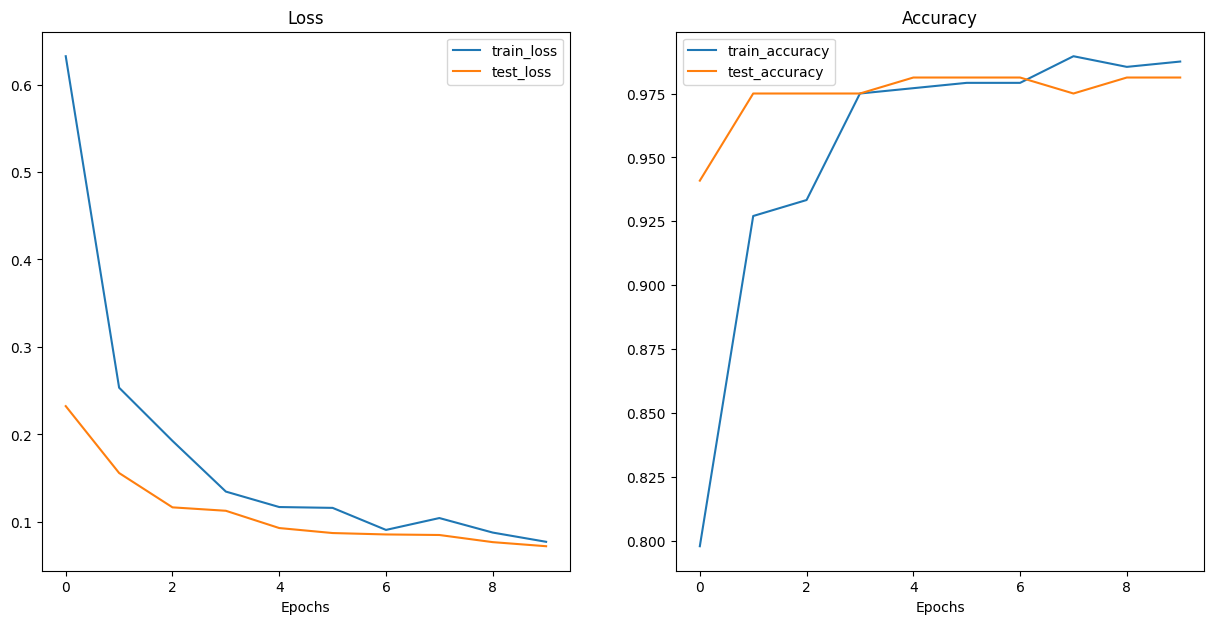

In [24]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

# 4. Try repeating the steps from excercise 3 but this time use the "ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1" pretrained weights from torchvision.models.vit_b_16().

In [25]:
set_seeds()
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights2 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # "DEFAULT" means best available
pretrained_vit2 = torchvision.models.vit_b_16(weights=vit_weights2)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit2.parameters():
  param.requires_grad = False

# Update the pretrained ViT head
embedding_dim = 768 # ViT_Base
pretrained_vit2.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

summary(model=pretrained_vit2,
        input_size=(1, 3, 384, 384),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:01<00:00, 180MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [26]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 384 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms_2 = vit_weights2.transforms()
manual_transforms_2

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [27]:
# Create 20% training and test data DataLoders
train_dataloader_20_percent_2, test_dataloader_2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=manual_transforms_2,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 20 percent training data: 15
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [28]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit2.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit2_results_2 = engine.train(model=pretrained_vit2,
                                      train_dataloader=train_dataloader_20_percent_2,
                                      test_dataloader=test_dataloader_2,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5009 | train_acc: 0.8750 | test_loss: 0.0553 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0695 | train_acc: 0.9854 | test_loss: 0.0273 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0449 | train_acc: 0.9896 | test_loss: 0.0168 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0337 | train_acc: 0.9938 | test_loss: 0.0125 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0267 | train_acc: 0.9938 | test_loss: 0.0103 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0231 | train_acc: 0.9938 | test_loss: 0.0090 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0185 | train_acc: 0.9979 | test_loss: 0.0077 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0230 | train_acc: 0.9979 | test_loss: 0.0069 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0143 | train_acc: 1.0000 | test_loss: 0.0076 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0135 | train_acc: 0.9979 | test_loss: 0.0059 | test_acc: 1.0000


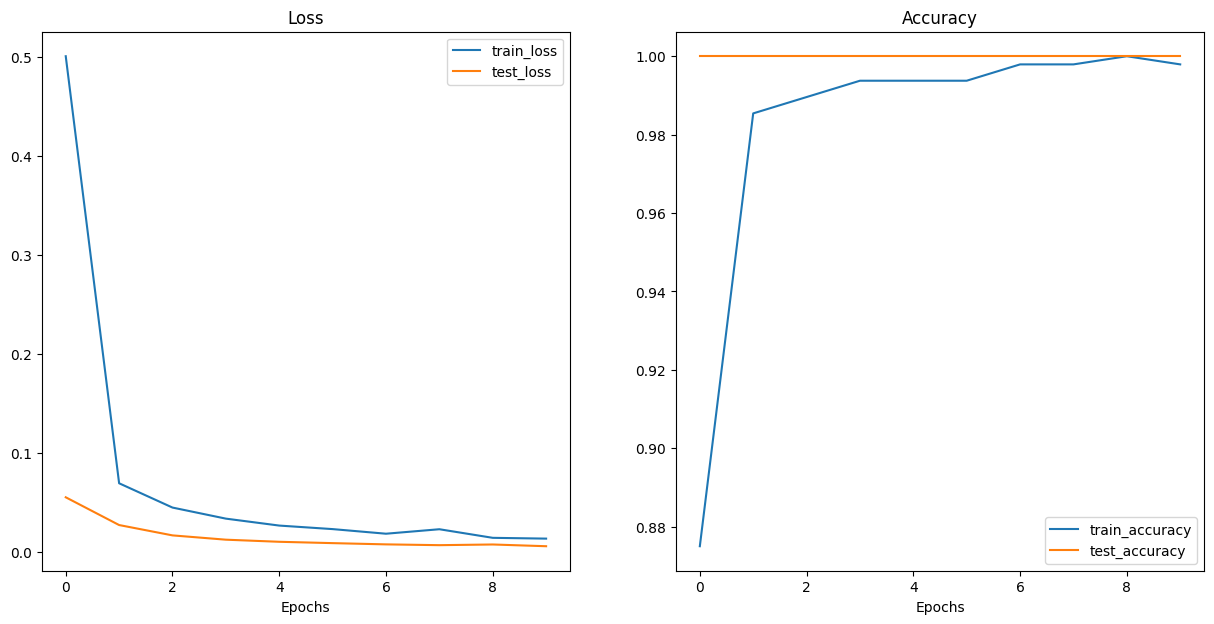

In [29]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit2_results_2)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
* ImageNet-21k pretraining (more data).
* Learning rate warmup.
* Learning rate decay.
* Gradient clipping.

## 5.1 ImageNet-21k pretraining (more data).

ImageNet-21k pretraining for the mases, the raw dataset is large (1.3 TB), consist of 14,197,122 images each tagged in a single-label fashion by one of 21,841 possible classes. The dataset has no official train-validation split, and the classes are not well-balanced- come classes contain only 1-10 saples, while others contain thousands of samples.

Comparing with our dataset, this is a humongous dataset.

## 5.2 Learning rate warmup.

Training warmup steps refer to an initial phase of training where the learning rate is gradually increased from a small value to the target learning rate over a specified numbe rof steps or epochs.

Comparing with our learning date that was fixed.

## 5.3 Learning rate decay

Is a technique that sometimes referred to as learning rate scheduling or learning rate annealing. Throughout the training phase, it entails gradually lowering the learning rate. It is used to gradually adjust the learning rate, usually by lowering it, to facilitate the optimization algorithm's more rapid convergence to a better solution.

## 5.4 Gradient clipping

It is the process that helps maintain numerical stability by preventing the gradients from growing too large. When training a neural network, the loss gradients are computed through backpropagation. However, if these gradients become too large, the updates to the model weights cna also become excessively large, leading to numerical instability. This can result in the model producing NaN (Not a Number) values or overflow errors, which cna be problematic.

By using Gradient Clipping, we can maintain numerical stability.

We didn't use it in our training thus this different results.